1. Q_puffing
    * puffing
    * NBI
    * SMBI
    * PI
2. Q_pumping

3. Q_plasma
4. Q_vacuum

# 1.Q_puffing

## 1.1 Gas Puffing

In [7]:
import MDSplus as mds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [8]:
# shot = int(input("shot: "))
# signal = input("signal: ")
shot = 100000

cn  = mds.Connection('mds.ipp.ac.cn')
cn.openTree('east_1', shot)

Get idx_begin(start time point), idx_end (end time point)

In [9]:
ip = cn.get('\ipg')
ip = ip.data()
time_ip = cn.get('dim_of(\ipg)').data()
idx_begin = 6000
idx_end = np.argwhere(ip > 10)[-1,0] # The return value of argwhere is row * 1
idx_end

17825

In [10]:
signals = ["JHG1","JHG4","JHG5","CDG1","DHG1"]
puffing = np.zeros(idx_end-idx_begin)

In [11]:
for signal in signals:
    pressure = cn.get(f'\\{signal}').data()
    if len(ip) <= 7000 and max(pressure) - min(pressure) <= 0.3:
        data = 0
    else:
        background = np.mean(pressure[:idx_begin])
        end_pressure = np.mean(pressure[idx_end:idx_end+1000])
        pressure = pressure[idx_begin:idx_end]
        pressure = savgol_filter(pressure, 1000,3)
        pressure[pressure>background] = background
        pressure[pressure<end_pressure] = end_pressure
        pressure = background-pressure

        Pam2P = 4.82e20 # 每pa立方米的粒子数
        kp = 2.5e4  # 充气规管的转换系数

        signal_volumes = {
                             "JHG1":3.118e-4,"JHG2":2.91e-4,"JHG3": 2.922e-4,"JHG4":2.99e-4,"JHG5":2.997e-4,"JHG6":2.949e-4,
                             "OUG1":1.4687e-3,"ODG1":1.4601e-3,"CDG1":6.792e-3,
                             "HDG1":6.75e-3,"KHG1":2.938e-4,"DHG1":2.919e-4}
        volume = signal_volumes[signal]
        pressure *= kp * volume * Pam2P
        pressure[pressure<1e18] = 0
        data = pressure
    puffing += data

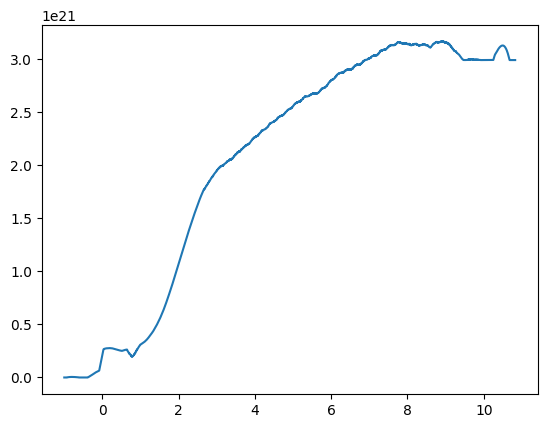

In [12]:
plt.plot(time_ip[idx_begin:idx_end],puffing)

## 1.2 SMBI

In [13]:
def get_SMBI(shot,which_one):
    gauges = np.array([['\pjs105', '\pjs103'],['\pjs205', '\pjs203'],['\pas105', '\pas103']])

    Pam2P = 4.82e20
    volume = 2.0431e-4
    which_gauge = 0
    if idx_end - idx_begin >= 1+1e5:
        volume = 2.0431e-4 + 3.78e-3
        which_gauge = 1
    gauge = gauges[which_one,which_gauge]
    pressure = cn.get(gauges[which_one,which_gauge]).data()
    
    if max(pressure)<0.1 and which_gauge == 0:
            volume = 2.0431e-4+3.78e-3
            which_gauge = 1
            gauge = gauges[which_one, which_gauge]
            pressure = cn.get(gauge).data()
    
    if which_gauge == 0 and max(pressure) > 9.8:
            which_gauge = 1
            gauge = gauges[which_one, which_gauge]
            pressure = cn.get(gauge).data()
    
    background = np.mean(pressure[:idx_begin])
    end_pressure = np.mean(pressure[idx_end:idx_end + 1000])
    pressure = pressure[idx_begin:idx_end]
    
    pressure = savgol_filter(pressure, 1000,3)
    
    if which_gauge == 0:
        pressure[pressure < background] = background
        pressure[pressure > end_pressure] = end_pressure
        kp = 2e3
        pressure = pressure - background
    else:
        pressure[pressure > background] = background
        pressure[pressure < end_pressure] = end_pressure
        kp = 4e5
        pressure = background - pressure
    
    pressure = pressure * kp * volume * Pam2P
    pressure[pressure < 1e18] = 0
    return pressure

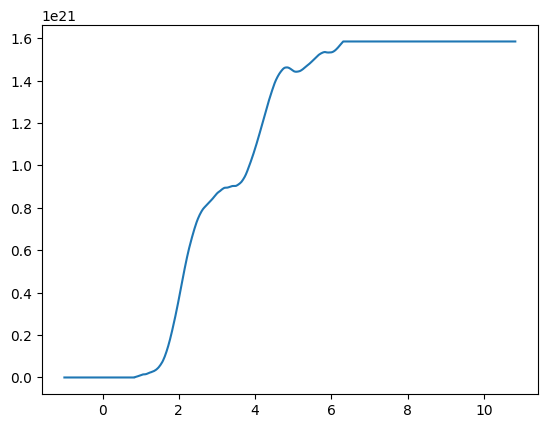

In [16]:
smbi2 = get_SMBI(shot,1)
plt.plot(time_ip[idx_begin:idx_end],smbi2)

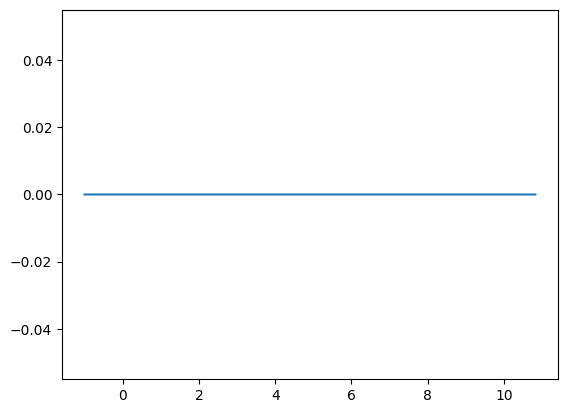

In [17]:
smbi3 = get_SMBI(shot,2)
plt.plot(time_ip[idx_begin:idx_end],smbi3)

## 1.3 NBI

In [18]:
def getNBI(shot):

    kp = 1e19 / 1.6
    NBI1LHI=0.8 * (cn.get('\\NBI1LHI')).data()
    NBI1RHI=0.8 * (cn.get('\\NBI1RHI')).data()
    NBI2LHI=0.8 * (cn.get('\\NBI2LHI')).data()
    NBI2RHI=0.8 * (cn.get('\\NBI2RHI')).data()
    # time_NBI=cn.get('dim_of(\\NBI2RHI)').data()

    background_NBI1LHI=np.mean(NBI1LHI[:idx_begin])
    NBI1LHI=NBI1LHI-background_NBI1LHI
    background_NBI1RHI=np.mean(NBI1RHI[:idx_begin])
    NBI1RHI=NBI1RHI-background_NBI1RHI
    background_NBI2RHI=np.mean(NBI2RHI[:idx_begin])
    NBI2RHI=NBI2RHI-background_NBI2RHI
    background_NBI2LHI=np.mean(NBI2LHI[:idx_begin])
    NBI2LHI=NBI2LHI-background_NBI2LHI
    NBI= NBI1LHI+NBI1RHI+NBI2LHI+NBI2RHI
    NBI = NBI[idx_begin:idx_end]
    NBI = NBI * kp

    NBI[NBI<5e18] = 0
    NBI[1:1000] = 0
    return NBI

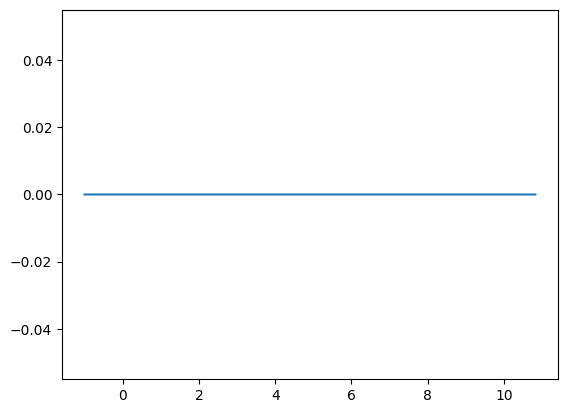

In [20]:
NBI = getNBI(100000)    #TODO: 找一炮有NBI注入的
plt.plot(time_ip[idx_begin:idx_end],NBI)

## 1.4 PI

In [24]:
def get_PI(shot):
    kp = 2e20
    PI = cn.get('\\vpi20').data()
    PI = PI[idx_begin:idx_end]
    PI = np.diff(PI)
    PI = np.append(PI,0)
    PI[PI<=4] = 0
    PI[PI>4] = 1
    PI = np.cumsum(PI)
    return kp * PI

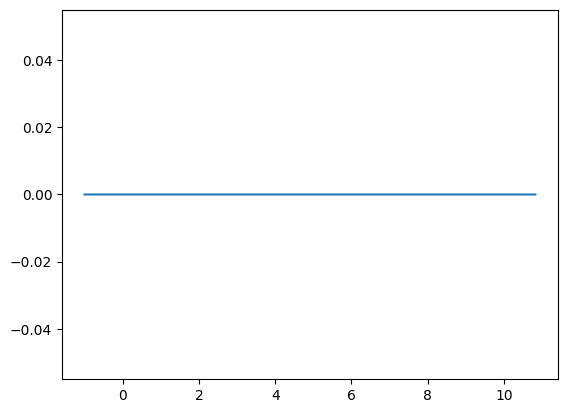

In [25]:
PI = get_PI(100000)
plt.plot(time_ip[idx_begin:idx_end],PI)

# 2. Pumping

In [26]:
def get_pump(shot):
    KD2 = 2.9
    Pam2P = 4.82e20
    HD = 0.5
    main_speed = 77
    up_speed = 67
    low_speed = 60.5

    G107 = cn.get('\\G107').data()
    if len(G107)<7000:
        G107 = cn.get('\\G101').data()


    G107 = G107[idx_begin:idx_end]
    G107 = 10 ** (1.667*G107-9.333)


    G106 = cn.get('\\G106').data()

    if max(G106)<1:
        G106 = G107
    else:
        G106 = G106[idx_begin:idx_end]
        G106 = 10 ** (1.667*G106-9.333)


    G109 = cn.get('\\G109').data()

    if max(G109)<1:
        G109 = G107
    else:
        G109 = G109[idx_begin:idx_end]
        G109 = 10 ** (1.667 * G109 - 9.333)


    data = up_speed*G109+low_speed*G106+main_speed*G107
    data = HD*KD2*Pam2P*data

    data[data<5e18] = 0
    data[1:1000] = 0


    return data

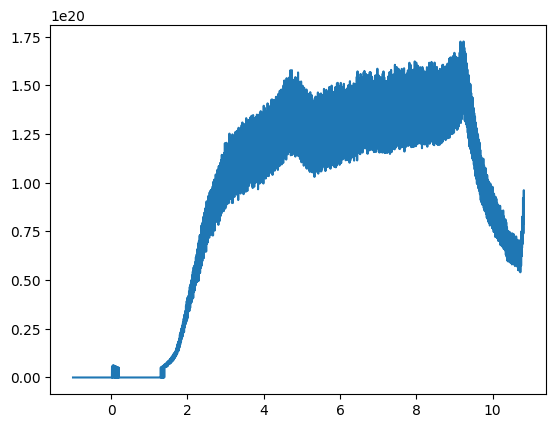

In [28]:
pump = get_pump(100000)
plt.plot(time_ip[idx_begin:idx_end],pump)

## 1.3 Q_plasma